# Speech Command Recognition 

## Import needed modules

In [2]:
import tensorflow as tf
import librosa
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import SpeechDownloader
import AudioGen
import speech_model


## Download data from google speech command dataset

In [3]:
gscInfo, nCategs = SpeechDownloader.PrepareGoogleSpeechCmd(version=2, task='35word')

Google Speech commands dataset version 2 already exists. Skipping download.
Converting test set WAVs to numpy files


0it [00:00, ?it/s]
0it [00:00, ?it/s]


Converting training set WAVs to numpy files
Done preparing Google Speech commands dataset version 2


# Audio Generator

In [4]:
#the default sampling rate for google speech command dataset
sr = 16000
iLen = sr
#We have four sets of dataset: train/val/test/testReal, in which train/val/test are used for training process
#and testReal is used for testing.

#As a result, we need to define 4 generator respectively for each set of data.
trainGen = AudioGen.AudioGen(gscInfo['train']['files'], gscInfo['train']['labels'], shuffle=True)
valGen   = AudioGen.AudioGen(gscInfo['val']['files'], gscInfo['val']['labels'], shuffle=True)
testGen  = AudioGen.AudioGen(gscInfo['test']['files'], gscInfo['test']['labels'], shuffle=False, batch_size=len(gscInfo['test']['files']))
testRGen = AudioGen.AudioGen(gscInfo['testREAL']['files'], gscInfo['testREAL']['labels'], shuffle=False, batch_size=len(gscInfo['testREAL']['files']))

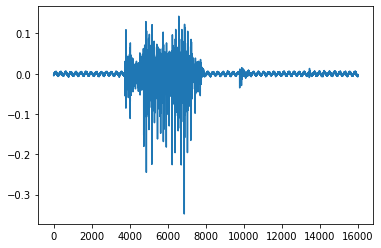

In [5]:
#The __getitem__ method in AudioGen is used to get a batch(32) of data
#The following code is used for check whether the generator works fine
audios_train, classes_train = trainGen.__getitem__(10)
audios_test, classes_test = testGen.__getitem__(15)
classes_train
plt.plot(audios_train[5])

In [6]:
#Before we define our model, we need to test whether our pre-processing of audios works fine.
#To test it, we create a model with keras with two simple layers: 
#One melspectrogram layer and one normalization2D layer. 

from tensorflow.keras.models import Sequential
from spela.melspectrogram import Melspectrogram
from spela.normalisation import Normalization2D
import numpy as np
import soundfile as sf
from scipy.fftpack import dct
import math
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Lambda
import tensorflow.keras.layers

melspecModel = Sequential()
melspecModel.add(Melspectrogram(n_dft=512, n_hop=128, input_shape=(1, iLen),
                         padding='same', sr=sr, n_mels=80,
                         fmin=40.0, fmax=sr/2, power_melgram=1.0,
                         return_decibel_melgram=True, trainable_fb=False,
                         trainable_kernel=False,
                         name='mel_stft') )
melspecModel.add(Normalization2D(int_axis=0))
melspecModel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mel_stft (Melspectrogram)    (None, 80, 125, 1)        283728    
_________________________________________________________________
normalization2d (Normalizati (None, 80, 125, 1)        0         
Total params: 283,728
Trainable params: 283,728
Non-trainable params: 0
_________________________________________________________________


In [7]:
melspec = melspecModel.predict(audios_train.reshape((-1,1,iLen)) )
melspec.shape

(32, 80, 125, 1)

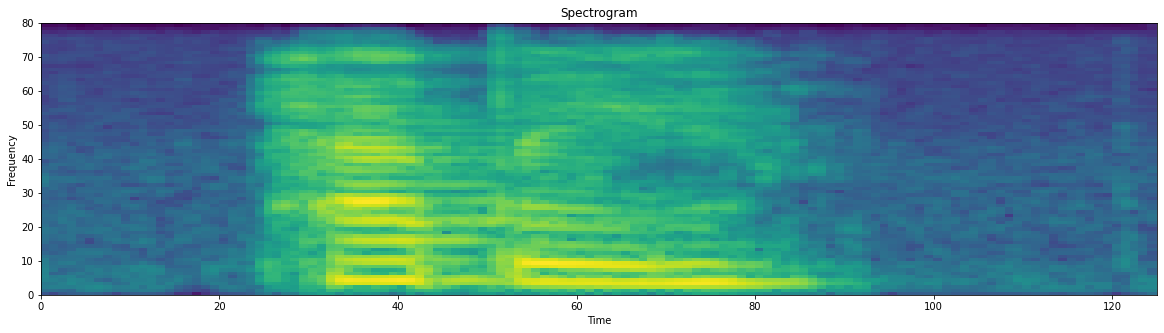

In [8]:
plt.figure(figsize=(20,5))
plt.pcolormesh(melspec[4,:,:,0])

plt.title('Spectrogram')
plt.xlabel('Time')
plt.ylabel('Frequency')

plt.show()

# Models

Create Keras models to see if the generators are working properly

In [9]:
import math
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from adjust_utils import *

- The First Model, Data Aug Included

Tested by Haikang Tan

In [23]:
#self-attention LSTM
#nCategs=36
#sr=16000
#iLen=16000
#from keras import layers as L

model_p1 = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_p1.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_p1.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_3 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_3[0][0]                  
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
____________________________________________________________________________________________

In [ ]:
lr_power_1 = LearningRateScheduler(power_decay_1)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

cp_p1 = ModelCheckpoint(filepath='model_attRNN_p1.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)
results_p1 = model_p1.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_p1, lr_power_1])

model_p1.save('model_attRNN_p1.h5')

## The Second Model, Data Aug not Included

Tested by **Huiyan Xing**

In [24]:
model_p2 = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_p2.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_p2.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape_4 (Reshape)             (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape_4[0][0]                  
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
____________________________________________________________________________________________

In [25]:
lr_power_2 = LearningRateScheduler(power_decay_2)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

cp_p2 = ModelCheckpoint(filepath='model_attRNN_p2.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results_p2 = model_p2.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_p2, lr_power_2])

model_p2.save('model_attRNN_p2.h5')

Changing learning rate to 0.001
Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.88937, saving model to model_attRNN_p2.h5
2651/2651 - 708s - loss: 0.8693 - sparse_categorical_accuracy: 0.7560 - val_loss: 0.4109 - val_sparse_categorical_accuracy: 0.8894 - lr: 0.0010
Changing learning rate to 0.000984987422935722
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy improved from 0.88937 to 0.91359, saving model to model_attRNN_p2.h5
2651/2651 - 661s - loss: 0.3482 - sparse_categorical_accuracy: 0.9022 - val_loss: 0.3119 - val_sparse_categorical_accuracy: 0.9136 - lr: 9.8499e-04
Changing learning rate to 0.0009699493779682662
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy improved from 0.91359 to 0.92414, saving model to model_attRNN_p2.h5
2651/2651 - 631s - loss: 0.2709 - sparse_categorical_accuracy: 0.9239 - val_loss: 0.2627 - val_sparse_categorical_accuracy: 0.9241 - lr: 9.6995e-04
Changing learning rate to 0.0009548853816214997
Epoch 4/60

- The Third Model

Tested by Jiawen Yan

In [15]:
model_e = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_e.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_e.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape[0][0]                    
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
______________________________________________________________________________________________

In [ ]:
lr_exp = LearningRateScheduler(exp_decay)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=10, verbose=1, restore_best_weights=True)

cp_e = ModelCheckpoint(filepath='model_attRNN_e.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results_e = model_e.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_e, lr_exp])

model_e.save('model_attRNN_e.h5')

## The Forth Model, Data Aug not Included

Tested by **Huiyan Xing**

In [10]:
model_m = speech_model.att_rnn_model(nCategs, samplingrate = sr, inputLength = None)
model_m.compile(optimizer='adam', loss=['sparse_categorical_crossentropy'], metrics=['sparse_categorical_accuracy'])
model_m.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input (InputLayer)              [(None, None)]       0                                            
__________________________________________________________________________________________________
reshape (Reshape)               (None, 1, None)      0           input[0][0]                      
__________________________________________________________________________________________________
Mel_Spec (Melspectrogram)       (None, 80, None, 1)  1091664     reshape[0][0]                    
__________________________________________________________________________________________________
Mel_Spec_Norm (Normalization2D) (None, 80, None, 1)  0           Mel_Spec[0][0]                   
______________________________________________________________________________________________

In [11]:
lr_multi = multi_decay(decay_frac=0.1)

earlystopper = EarlyStopping(monitor='val_sparse_categorical_accuracy', patience=5, verbose=1, restore_best_weights=True)

cp_m = ModelCheckpoint(filepath='model_attRNN_m.h5', monitor='val_sparse_categorical_accuracy', verbose=1, save_best_only=True)

results_m = model_m.fit(trainGen, validation_data=valGen, epochs=60, use_multiprocessing=False, workers=4, verbose=2,
                    callbacks=[earlystopper, cp_m, lr_multi])

model_m.save('model_attRNN_m.h5')

Epoch 1/60

Epoch 00001: val_sparse_categorical_accuracy improved from -inf to 0.88334, saving model to model_attRNN_m.h5
2651/2651 - 794s - loss: 0.7869 - sparse_categorical_accuracy: 0.7802 - val_loss: 0.4231 - val_sparse_categorical_accuracy: 0.8833 - lr: 0.0010
Epoch 2/60

Epoch 00002: val_sparse_categorical_accuracy improved from 0.88334 to 0.92182, saving model to model_attRNN_m.h5
2651/2651 - 755s - loss: 0.3516 - sparse_categorical_accuracy: 0.9005 - val_loss: 0.2751 - val_sparse_categorical_accuracy: 0.9218 - lr: 0.0010
Epoch 3/60

Epoch 00003: val_sparse_categorical_accuracy improved from 0.92182 to 0.92795, saving model to model_attRNN_m.h5
2651/2651 - 971s - loss: 0.2740 - sparse_categorical_accuracy: 0.9225 - val_loss: 0.2657 - val_sparse_categorical_accuracy: 0.9280 - lr: 0.0010
Epoch 4/60

Epoch 00004: val_sparse_categorical_accuracy improved from 0.92795 to 0.93288, saving model to model_attRNN_m.h5
2651/2651 - 881s - loss: 0.2306 - sparse_categorical_accuracy: 0.9337 -

## History Plot

### History of The Second Model

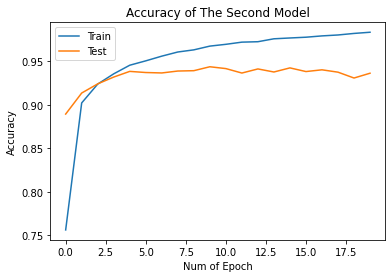

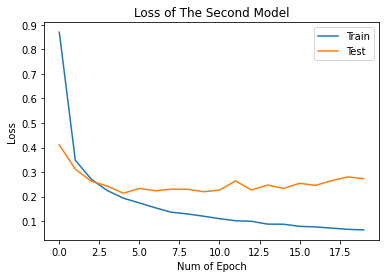

In [27]:
# summarize history for categorical accuracy
plt.plot(results_p2.history['sparse_categorical_accuracy'])
plt.plot(results_p2.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy of The Second Model')
plt.ylabel('Accuracy')
plt.xlabel('Num of Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results_p2.history['loss'])
plt.plot(results_p2.history['val_loss'])
plt.title('Loss of The Second Model')
plt.ylabel('Loss')
plt.xlabel('Num of Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [29]:
model_p2.load_weights('model_attRNN_p2.h5')

In [30]:
#read all test data
x_test, y_test = testGen.__getitem__(0)

In [32]:
val_eval_sco = model_p2.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
train_eval_sco = model_p2.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
test_eval_sco = model_p2.evaluate(x_test, y_test, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model_p2.metrics_names, train_eval_sco, val_eval_sco, test_eval_sco) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.09742730855941772, 0.9732530117034912] 
Validation: [0.21138827502727509, 0.9442323446273804] 
Test: [0.2312031239271164, 0.9374829530715942]


### History of The Forth Model

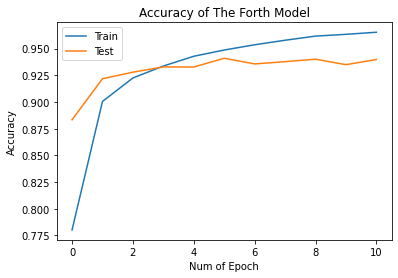

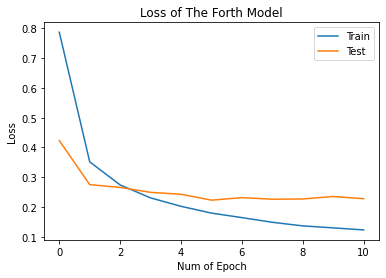

In [12]:
# summarize history for categorical accuracy
plt.plot(results_m.history['sparse_categorical_accuracy'])
plt.plot(results_m.history['val_sparse_categorical_accuracy'])
plt.title('Accuracy of The Forth Model')
plt.ylabel('Accuracy')
plt.xlabel('Num of Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(results_m.history['loss'])
plt.plot(results_m.history['val_loss'])
plt.title('Loss of The Forth Model')
plt.ylabel('Loss')
plt.xlabel('Num of Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()

In [13]:
model_m.load_weights('model_attRNN_m.h5')
x_test_m, y_test_m = testGen.__getitem__(0)

In [14]:
val_eval_sco_m = model_m.evaluate(valGen, use_multiprocessing=False, workers=4,verbose=0)
train_eval_sco_m = model_m.evaluate(trainGen, use_multiprocessing=False, workers=4,verbose=0)
test_eval_sco_m = model_m.evaluate(x_test_m, y_test_m, verbose=0)
print('Evaluation scores: \nMetrics: {} \nTrain: {} \nValidation: {} \nTest: {}'.format(model_m.metrics_names, train_eval_sco_m, val_eval_sco_m, test_eval_sco_m) )

Evaluation scores: 
Metrics: ['loss', 'sparse_categorical_accuracy'] 
Train: [0.15259180963039398, 0.9572920799255371] 
Validation: [0.21598082780838013, 0.9424236416816711] 
Test: [0.23812879621982574, 0.9305770397186279]


## Evaluation & Confusion Matrix

In [16]:
from tensorflow.keras.models import Model, load_model

### Evaluation of The Second Model

In [35]:
attSpeechModel_p2 = Model(inputs=model_p2.input, outputs=[model_p2.get_layer('output').output, model_p2.get_layer('Att_weighted_Softmax').output, model_p2.get_layer('Mel_Spec').output])

In [36]:
audios_p2, classes_p2 = valGen.__getitem__(3)
classes_p2

array([20, 24,  2, 16, 15, 33,  8, 20, 18, 31,  2,  9, 16,  9, 10, 27,  9,
       33, 12, 13, 29,  8,  2,  8, 15, 10, 10, 12, 15, 23,  6,  8])

In [37]:
#8 - on, 13 - one, 7 - right
idAudio = 13
classes_p2[13]

9

In [38]:
outs_p2, attW_p2, specs_p2 = attSpeechModel_p2.predict(audios_p2)

In [39]:
np.argmax(outs_p2,axis=1)

array([20, 24,  2, 16, 15, 33,  8, 20, 18, 31,  2,  8, 27,  9, 10, 27,  9,
       33, 12, 13, 29,  8,  2,  8, 15, 10, 10, 12, 15, 23,  6, 12])

In [40]:
specs_p2.shape

(32, 80, 125, 1)

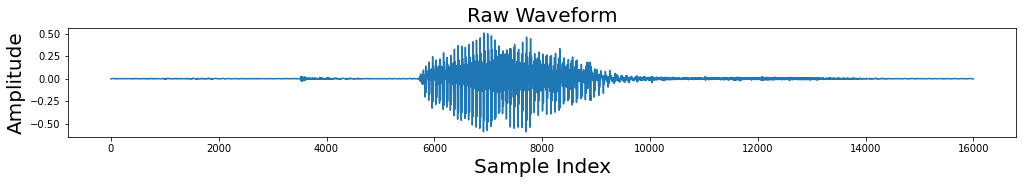

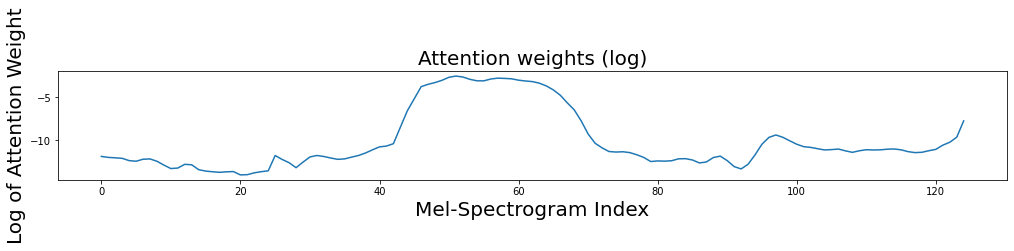

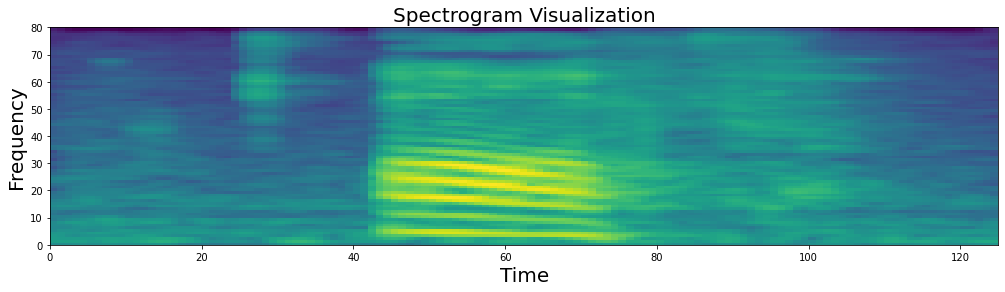

In [42]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw Waveform', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.xlabel('Sample Index', fontsize=20)
plt.plot(audios_p2[idAudio])
plt.savefig('pic_raw_wave_p2.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=20)
plt.ylabel('Log of Attention Weight', fontsize=20)
plt.xlabel('Mel-Spectrogram Index', fontsize=20)
plt.plot(np.log(attW_p2[idAudio]))
plt.savefig('pic_att_weight_p2.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs_p2[idAudio,:,:,0])
plt.title('Spectrogram Visualization', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.savefig('pic_mel_spec_freq_p2.png', dpi = 400)
plt.show()

In [43]:
y_pred_p2 = model_p2.predict(x_test, verbose=1)

344/344 [==============================] - 23s 67ms/step


In [44]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test, np.argmax(y_pred_p2,1))

In [45]:
#35word, v2
classes_p2 = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

No Normalization


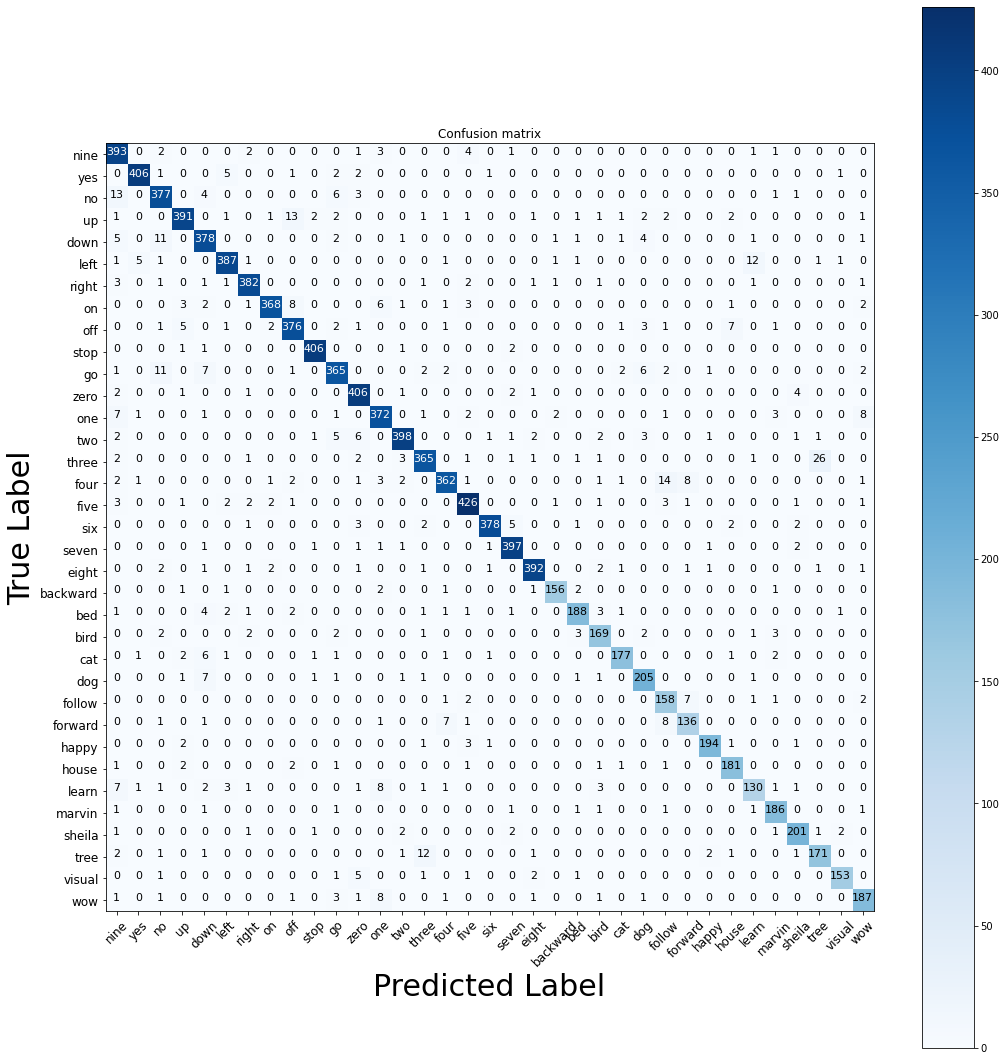

In [46]:
audioUtils.plot_confusion_matrix(cm, classes_p2, normalize=False)

### Evaluation of The Forth Model

In [17]:
attSpeechModel_m = Model(inputs=model_m.input, outputs=[model_m.get_layer('output').output, model_m.get_layer('Att_weighted_Softmax').output, model_m.get_layer('Mel_Spec').output])

In [18]:
audios_m, classes_m = valGen.__getitem__(3)
idAudio = 13
classes_m[13]

2

In [19]:
outs_m, attW_m, specs_m = attSpeechModel_m.predict(audios_m)

In [20]:
np.argmax(outs_m,axis=1)
specs_m.shape

(32, 80, 125, 1)

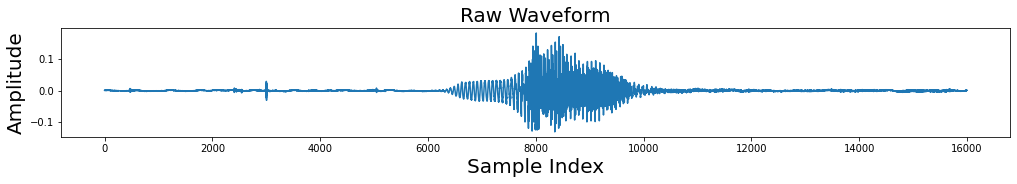

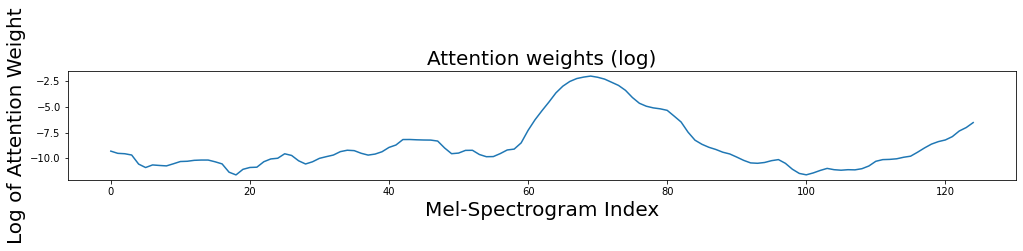

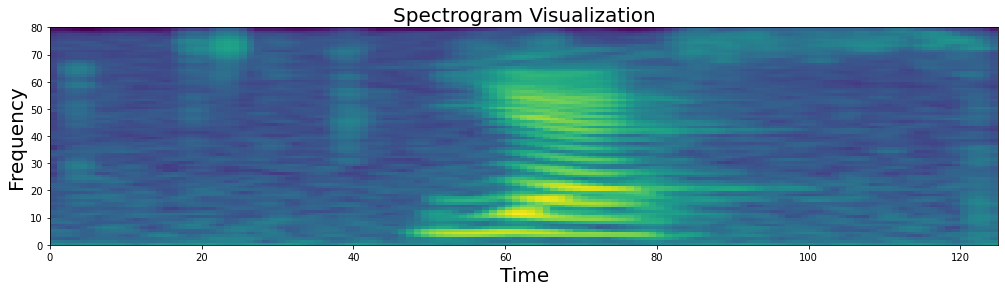

In [21]:
imgHeight = 2

plt.figure(figsize=(17,imgHeight))
plt.title('Raw Waveform', fontsize=20)
plt.ylabel('Amplitude', fontsize=20)
plt.xlabel('Sample Index', fontsize=20)
plt.plot(audios_m[idAudio])
plt.savefig('pic_raw_wave_m.png', dpi = 400)
plt.show()

plt.figure(figsize=(17,imgHeight))
plt.title('Attention weights (log)', fontsize=20)
plt.ylabel('Log of Attention Weight', fontsize=20)
plt.xlabel('Mel-Spectrogram Index', fontsize=20)
plt.plot(np.log(attW_m[idAudio]))
plt.savefig('pic_att_weight_p2.png', dpi = 400)
plt.show()


plt.figure(figsize=(17,imgHeight*2))
plt.pcolormesh(specs_m[idAudio,:,:,0])
plt.title('Spectrogram Visualization', fontsize=20)
plt.ylabel('Frequency', fontsize=20)
plt.xlabel('Time', fontsize=20)
plt.savefig('pic_mel_spec_freq_m.png', dpi = 400)
plt.show()

In [22]:
y_pred_m = model_m.predict(x_test_m, verbose=1)

344/344 [==============================] - 23s 65ms/step


In [23]:
from sklearn.metrics import confusion_matrix
import audioUtils
cm = confusion_matrix(y_test_m, np.argmax(y_pred_m,1))

In [24]:
#35word, v2
classes_m = ['nine', 'yes', 'no', 'up', 'down', 'left', 'right', 'on', 'off', 'stop', 'go',
           'zero', 'one', 'two', 'three', 'four', 'five', 'six', 
           'seven',  'eight', 'backward', 'bed', 'bird', 'cat', 'dog',
           'follow', 'forward', 'happy', 'house', 'learn', 'marvin', 'sheila', 'tree',
           'visual', 'wow']

No Normalization


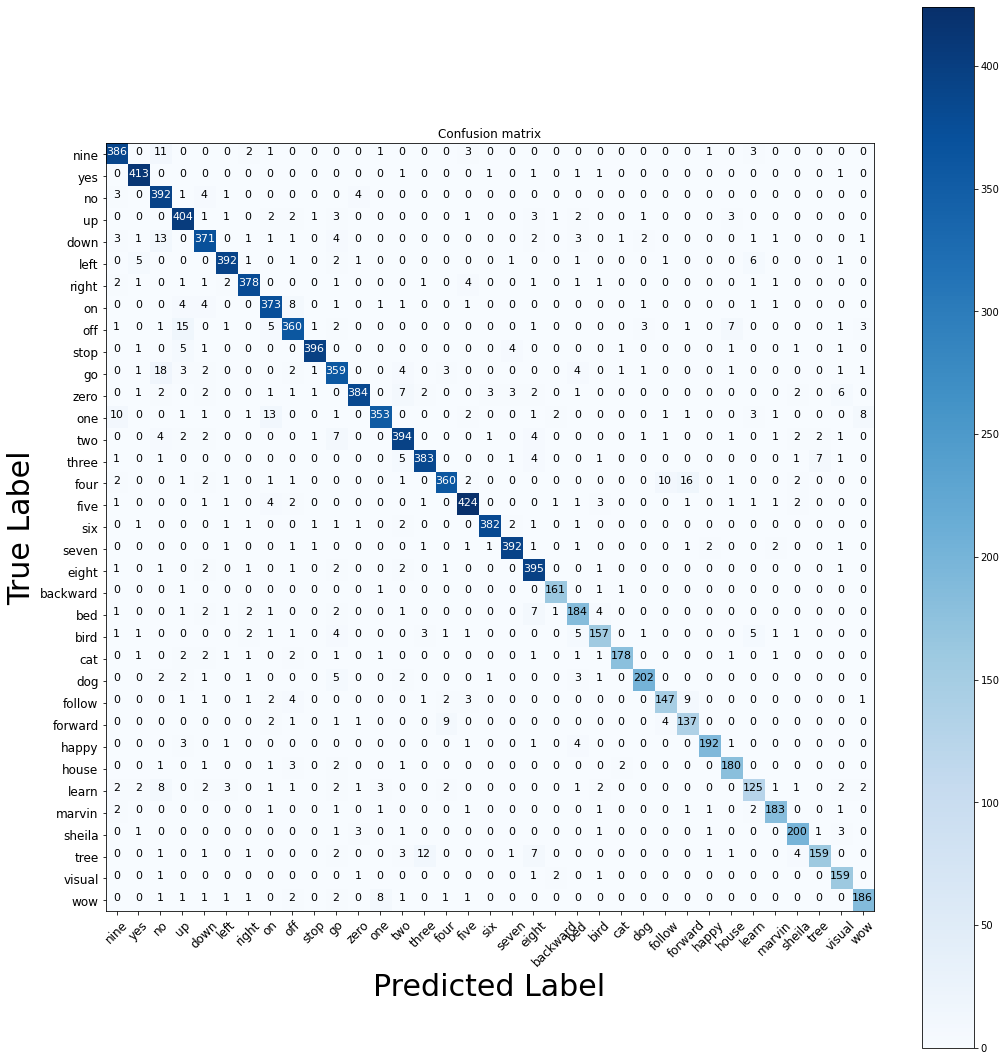

In [25]:
audioUtils.plot_confusion_matrix(cm, classes_m, normalize=False)